In [1]:
import os
import json
import pandas as pd

os.listdir("./results")

# ['exp2_concat_views', 'exp1_manyKL_losses', 'exp3_gaussian_fusion']
# Each with:
    # ['single_view_fp_plain_-8054598309511539763.json',
    #  'single_view_emb_variational_5282197061669233432.json',
    #  'multi_view_variational_4453866053670671622.json',
    # ...

# e.g.
# {
#     "experiment": "multi_view_plain_-46151256717262646",
#     "learning_rate": 0.0005,
#     "batch_size": 32,
#     "depth": 1,
#     "hidden_dim": 256,
#     "latent_dim": 256,
#     "dropout_prob": 0.3,
#     "best_valid_loss": 0.3437898400660655,
#     "test_loss": 0.3843511521654285,
#     "num_trainable_params": 4510870,
#     "runtime": 201.72464776039124
# }

['exp2_concat_views', 'exp1_manyKL_losses', 'exp3_gaussian_fusion']

In [2]:
# Iterate over all json files in the results directory and create dataframe
results = []
prefixes = []

for folder in os.listdir("./results"):
    for file in os.listdir(f"./results/{folder}"):
        with open(f"./results/{folder}/{file}") as f:
            results.append(json.load(f))
            prefixes.append(f"{folder[:4]}_")

df = pd.DataFrame(results)
df["experiment"] = pd.Series(prefixes) + df["experiment"]
df.head(5)

,experiment,learning_rate,batch_size,depth,hidden_dim,latent_dim,dropout_prob,kl_weight,best_valid_loss,test_loss,num_trainable_params,runtime
0,exp2_single_view_emb_variational_3529412956370...,0.00005,128,0,64,128,0.2,0.0001,0.324094,0.435451,131712,375.289309
1,exp2_single_view_fp_variational_42385414598752...,0.00010,128,3,64,512,0.2,0.0010,0.361880,0.391034,581888,425.603256
2,exp2_single_view_emb_plain_-6918109421305584377,0.00010,64,2,64,512,0.4,NaN,0.311795,0.399881,198784,185.536258
3,exp2_single_view_fp_plain_-5547327886985634102,0.00100,32,3,64,512,0.2,NaN,0.326292,0.350322,515328,225.486356
4,exp2_multi_view_variational_-7456501636105464832,0.00010,16,3,256,128,0.2,0.0001,0.334929,0.384105,7126016,514.918080


In [3]:
import numpy as np

def find_outliers(df, column='test_loss', threshold=3):
    """
    Identifies outliers using z-score method
    Returns DataFrame with outliers removed and prints outlier info
    """
    z_scores = np.abs((df[column] - df[column].mean()) / df[column].std())
    outliers = df[z_scores > threshold]
    if len(outliers) > 0:
        print(f"\nFound {len(outliers)} outliers in {column}:")
        print(outliers[['experiment', column, 'best_valid_loss']])
    
    return df[z_scores <= threshold]

def categorize_experiments(df):
    """
    Categorizes experiments into 6 groups for each experiment type (1 and 2)
    Returns a dictionary of dataframes
    """
    categories = {
        # Experiment 1 (AttnAgg)
        'exp1': {
            'single_fp_plain': df[df['experiment'].str.contains('exp1_single_view_fp_plain')],
            'single_emb_plain': df[df['experiment'].str.contains('exp1_single_view_emb_plain')],
            'multi_plain': df[df['experiment'].str.contains('exp1_multi_view_plain')],
            'single_fp_var': df[df['experiment'].str.contains('exp1_single_view_fp_variational')],
            'single_emb_var': df[df['experiment'].str.contains('exp1_single_view_emb_variational')],
            'multi_var': df[df['experiment'].str.contains('exp1_multi_view_variational')]
        },
        # Experiment 2 (Concat)
        'exp2': {
            'single_fp_plain': df[df['experiment'].str.contains('exp2_single_view_fp_plain')],
            'single_emb_plain': df[df['experiment'].str.contains('exp2_single_view_emb_plain')],
            'multi_plain': df[df['experiment'].str.contains('exp2_multi_view_plain')],
            'single_fp_var': df[df['experiment'].str.contains('exp2_single_view_fp_variational')],
            'single_emb_var': df[df['experiment'].str.contains('exp2_single_view_emb_variational')],
            'multi_var': df[df['experiment'].str.contains('exp2_multi_view_variational')]
        },
        # Experiment 3 (GaussFusion)
        'exp3': {
            'single_fp_plain': df[df['experiment'].str.contains('exp3_single_view_fp_plain')],
            'single_emb_plain': df[df['experiment'].str.contains('exp3_single_view_emb_plain')],
            'multi_plain': df[df['experiment'].str.contains('exp3_multi_view_plain')],
            'single_fp_var': df[df['experiment'].str.contains('exp3_single_view_fp_variational')],
            'single_emb_var': df[df['experiment'].str.contains('exp3_single_view_emb_variational')],
            'multi_var': df[df['experiment'].str.contains('exp3_multi_view_variational')]
        },
        # Experiment 4 (MixtureFusion)
    }
    return categories

def print_category_sizes(categories):
    """
    Prints the number of experiments in each category
    """
    for exp_type, exp_dict in categories.items():
        print(f"\n{exp_type.upper()} Experiment Sizes:")
        print("Non-variational models:")
        print(f"  Simple fingerprint: {len(exp_dict['single_fp_plain'])}")
        print(f"  Intricate embeddings: {len(exp_dict['single_emb_plain'])}")
        print(f"  Multi-view: {len(exp_dict['multi_plain'])}")
        print("Variational models:")
        print(f"  Simple fingerprint: {len(exp_dict['single_fp_var'])}")
        print(f"  Intricate embeddings: {len(exp_dict['single_emb_var'])}")
        print(f"  Multi-view: {len(exp_dict['multi_var'])}")

# Split the experiments
df = find_outliers(df)
categories = categorize_experiments(df)
print_category_sizes(categories)


Found 1 outliers in test_loss:
                                           experiment     test_loss  \
4743  exp1_multi_view_variational_-835579993305963966  1.253818e+10   

      best_valid_loss  
4743     3.730709e+09  

EXP1 Experiment Sizes:
Non-variational models:
  Simple fingerprint: 486
  Intricate embeddings: 486
  Multi-view: 486
Variational models:
  Simple fingerprint: 1390
  Intricate embeddings: 1458
  Multi-view: 1005

EXP2 Experiment Sizes:
Non-variational models:
  Simple fingerprint: 521
  Intricate embeddings: 443
  Multi-view: 225
Variational models:
  Simple fingerprint: 1162
  Intricate embeddings: 1185
  Multi-view: 892

EXP3 Experiment Sizes:
Non-variational models:
  Simple fingerprint: 1152
  Intricate embeddings: 0
  Multi-view: 864
Variational models:
  Simple fingerprint: 1728
  Intricate embeddings: 0
  Multi-view: 1296


/tmp/ipykernel_314575/4048553682.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
/tmp/ipykernel_314575/4048553682.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
/tmp/ipykernel_314575/4048553682.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)


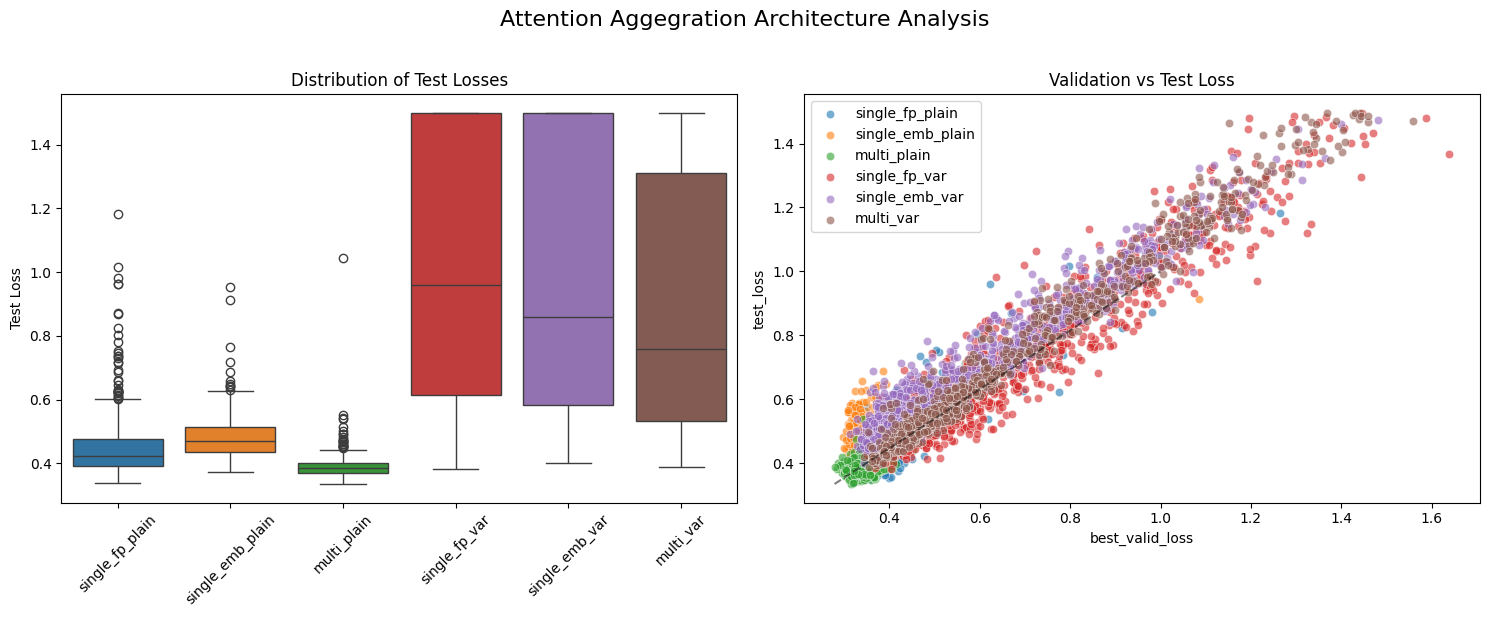

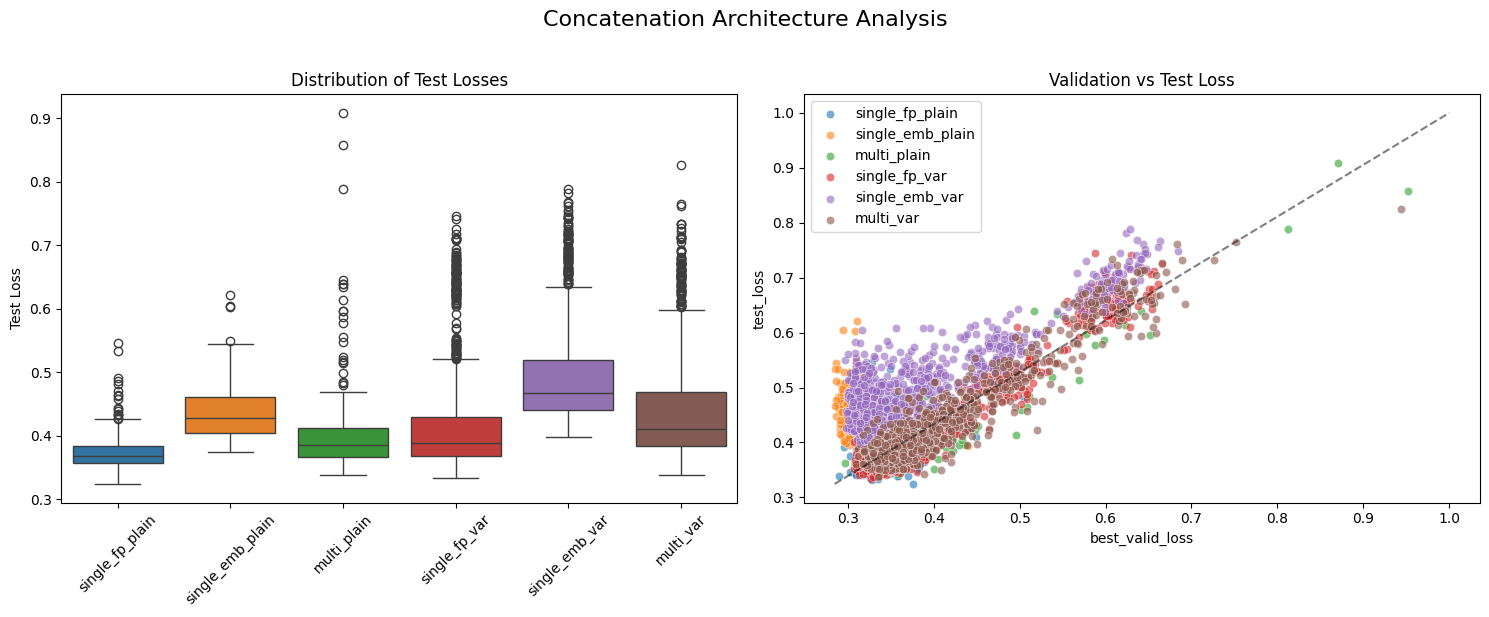

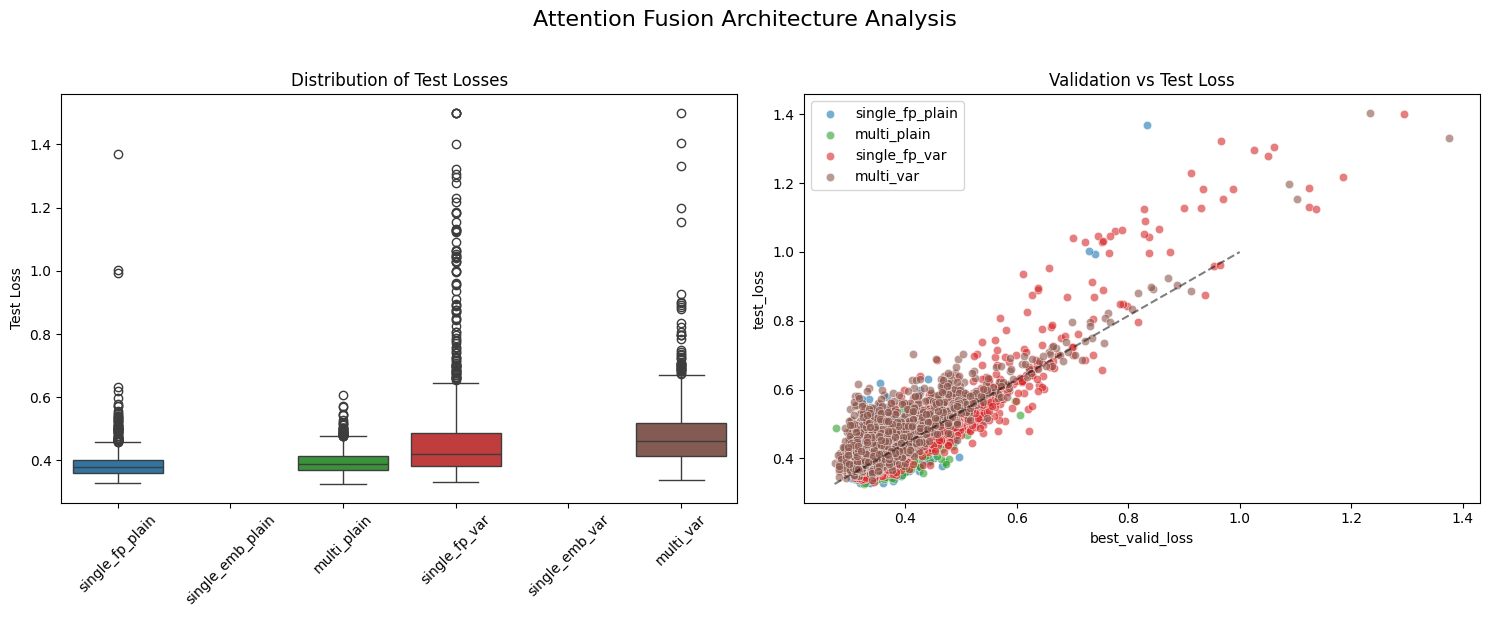

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_performance_comparison(categories, exp_type='exp1'):
    """
    Creates improved visualization focusing on loss distributions
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    if exp_type=="exp1":
        title = "Attention Aggegration"
    elif exp_type=="exp2":
        title = "Concatenation"
    elif exp_type=="exp3":
        title = "Attention Fusion"
    elif exp_type=="exp4":
        title = "Attention Aggegration2"

    fig.suptitle(f'{title} Architecture Analysis', 
                 fontsize=16, y=1.02)
    
    # 1. Box Plot of Test Losses (capped at 1.5)
    data_dict = {k: np.minimum(v['test_loss'], 1.5) for k, v in categories[exp_type].items()}
    sns.boxplot(data=data_dict, ax=ax1)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
    ax1.set_title('Distribution of Test Losses')
    ax1.set_ylabel('Test Loss')
    
    # 2. Validation vs Test Loss with min point highlighted
    for name, df_cat in categories[exp_type].items():
        df_cat = df_cat[df_cat["test_loss"] <= 1.5]
        sns.scatterplot(data=df_cat, x='best_valid_loss', y='test_loss',
                       label=name, ax=ax2, alpha=0.6)
    
    # Find minimum losses
    min_valid = min(df_cat['best_valid_loss'].min() 
                   for df_cat in categories[exp_type].values())
    min_test = min(df_cat['test_loss'].min() 
                  for df_cat in categories[exp_type].values())
    
    # Draw diagonal from min point
    ax2.plot([min_valid, 1], [min_test, 1], 'k--', alpha=0.5)
    
    ax2.set_title('Validation vs Test Loss')
    plt.tight_layout()
    return fig

# Create plots for both experiments
fig1 = plot_performance_comparison(categories, 'exp1')
fig2 = plot_performance_comparison(categories, 'exp2')
fig3 = plot_performance_comparison(categories, 'exp3')

In [10]:
def get_top_n_models(categories, n=5):
    """
    Gets the top N performing models for each category based on test loss
    Returns a dictionary of dataframes with the same structure as categories
    """
    top_models = {
        'exp1': {},
        'exp2': {},
        'exp3': {}
    }
    
    for exp_type in ['exp1', 'exp2', 'exp3']:
        for category, df in categories[exp_type].items():
            # Sort by test_loss and take top N
            top_models[exp_type][category] = df.nsmallest(n, 'best_valid_loss')[
                [
                    'test_loss', 'num_trainable_params', 'runtime',
                    'learning_rate', 'batch_size', 'kl_weight', 'dropout_prob',
                    'depth', 'hidden_dim', 'latent_dim'
                ]
            ]
    
    return top_models

def display_results_table(top_models):
    """
    Creates a formatted pandas DataFrame showing metrics for each model type
    """
    # Create MultiIndex for columns
    cols = pd.MultiIndex.from_tuples([
        ('Non-variational', 'FP'),
        ('Non-variational', 'EMB'),
        ('Non-variational', 'multi-view'),
        ('Variational', 'FP'),
        ('Variational', 'EMB'),
        ('Variational', 'multi-view'),
    ], names=['Model Type', 'View(s)'])
    
    # Create MultiIndex for rows
    rows = pd.MultiIndex.from_tuples([
        # https://github.com/robsyc/MB-VAE-DTI/blob/c325d81d165485d372bbefc42e23ed6472a63fce/utils/modelBuilding.py#L144C1-L176C10
        ('AttnAgg', 'MSE'),
        ('AttnAgg', 'Params'),
        ('AttnAgg', 'Time (m)'),
        # https://github.com/robsyc/MB-VAE-DTI/blob/c773a8bb3aabb89c0623442a573bd2779a30b0d9/utils/modelBuilding.py#L123C1-L125C62
        ('Concat', 'MSE'),
        ('Concat', 'Params'),
        ('Concat', 'Time (m)'),
        # current ...
        ('AttnFusion', 'MSE'),
        ('AttnFusion', 'Params'),
        ('AttnFusion', 'Time (m)'),
    ], names=['Experiment', ''])
    
    # Initialize empty DataFrame
    df = pd.DataFrame(index=rows, columns=cols)
    
    # Fill the DataFrame
    for exp_type in ['exp1', 'exp2', 'exp3']:
        if exp_type == 'exp1':
            exp_name = 'AttnAgg'
        elif exp_type == 'exp2':
            exp_name = 'Concat'
        elif exp_type == 'exp3':
            exp_name = 'AttnFusion'
        
        for model_type in ['plain', 'var']:
            model_group = 'Non-variational' if model_type == 'plain' else 'Variational'
            
            for arch in ['fp', 'emb', 'multi']:
                view_name = 'FP' if arch == 'fp' else ('EMB' if arch == 'emb' else 'multi-view')
                key = f"{'single_' if arch != 'multi' else ''}{arch}_{model_type}"
                data = top_models[exp_type][key]
                
                # Calculate metrics
                loss = f"{data['test_loss'].mean():.3f} ± {data['test_loss'].std():.3f}"
                try:
                    params = f"{int(data['num_trainable_params'].mean()/1000)}K"
                    runtime = f"{round(data['runtime'].mean()/60, 1)}"
                except:
                    params = "NaN"
                    runtime = "NaN"
                
                # Fill DataFrame
                df.loc[(exp_name, 'MSE'), (model_group, view_name)] = loss
                df.loc[(exp_name, 'Params'), (model_group, view_name)] = params
                df.loc[(exp_name, 'Time (m)'), (model_group, view_name)] = runtime
    
    # Style the DataFrame
    styled_df = df.style.set_properties(**{
        'text-align': 'center',
        'padding': '10px',
    }).set_table_styles([
        {'selector': 'th', 'props': [
            ('text-align', 'center'),
            ('padding', '10px'),
            ('font-weight', 'bold')
        ]},
        {'selector': '', 'props': [
            ('border', '1px solid #ddd'),
            ('border-collapse', 'collapse')
        ]},
    ])
    
    return styled_df

# Get top 5 models and display results
top_models = get_top_n_models(categories, n=5)
styled_df = display_results_table(top_models)
display(styled_df)

In [15]:
0.365**0.5 # RMSE value (IBM: 0.44 & Gorantla: 0.48) but these are probably in setting A ...

0.6041522986797286

In [11]:
for exp in top_models:
    print("Experiment: ", exp)
    for model in top_models[exp]:
        print("Model: ", model)
        print(top_models[exp][model].drop(columns=["test_loss", "num_trainable_params", "runtime"]).to_markdown(), '\n')
    print("\n---\n")

Experiment:  exp1
Model:  single_fp_plain
|      |   learning_rate |   batch_size |   kl_weight |   dropout_prob |   depth |   hidden_dim |   latent_dim |
|-----:|----------------:|-------------:|------------:|---------------:|--------:|-------------:|-------------:|
| 6026 |          0.001  |          128 |         nan |            0.3 |       3 |          256 |         1024 |
| 8997 |          0.001  |          128 |         nan |            0.3 |       1 |          128 |         1024 |
| 7812 |          0.0005 |          128 |         nan |            0.3 |       1 |          128 |          256 |
| 7010 |          0.001  |          128 |         nan |            0.3 |       3 |          256 |          512 |
| 9053 |          0.0005 |          128 |         nan |            0.3 |       2 |          256 |         1024 | 

Model:  single_emb_plain
|      |   learning_rate |   batch_size |   kl_weight |   dropout_prob |   depth |   hidden_dim |   latent_dim |
|-----:|----------------:|-